In [3]:
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
def extract_features_from_annotation(file_path):
    data = []

    with open(file_path, 'r') as f:
        lines = f.readlines()

    # Skip the first 2 lines (fall period)
    frames = lines[2:]

    for line in frames:
        values = line.strip().split()
        if len(values) != 21:
            continue  # Skip corrupted lines
        frame_data = [float(v) for v in values]
        data.append(frame_data)

    data = np.array(data)

    if data.shape[0] == 0:
        return None  # Empty file or only missing data

    frames_num = data[:, 0]
    keypoints = data[:, 1:]

    # Compute center point from mid-shoulders (bx1, by1) and mid-hips (bx2, by2)
    centers_x = []
    centers_y = []
    aspect_ratios = []
    missing_counts = 0

    for kp in keypoints:
        if -1 in kp[:4]:  # If shoulder or hip points missing
            missing_counts += 1
            continue

        shoulder_x, shoulder_y = kp[0], kp[1]
        hip_x, hip_y = kp[2], kp[3]
        center_x = (shoulder_x + hip_x) / 2
        center_y = (shoulder_y + hip_y) / 2

        width = abs(shoulder_x - hip_x)
        height = abs(shoulder_y - hip_y)
        aspect_ratio = width / (height + 1e-6)  # Avoid division by zero

        centers_x.append(center_x)
        centers_y.append(center_y)
        aspect_ratios.append(aspect_ratio)

    centers_x = np.array(centers_x)
    centers_y = np.array(centers_y)
    aspect_ratios = np.array(aspect_ratios)

    # Calculate velocity and acceleration
    velocity_x = np.diff(centers_x)
    velocity_y = np.diff(centers_y)
    velocity_center = np.sqrt(velocity_x**2 + velocity_y**2)

    acceleration_center = np.diff(velocity_center)

    # Features
    features = {
        'mean_center_x': np.mean(centers_x) if len(centers_x) > 0 else 0,
        'mean_center_y': np.mean(centers_y) if len(centers_y) > 0 else 0,
        'std_center_x': np.std(centers_x) if len(centers_x) > 0 else 0,
        'std_center_y': np.std(centers_y) if len(centers_y) > 0 else 0,
        'mean_aspect_ratio': np.mean(aspect_ratios) if len(aspect_ratios) > 0 else 0,
        'max_velocity_center': np.max(velocity_center) if len(velocity_center) > 0 else 0,
        'mean_acceleration_center': np.mean(acceleration_center) if len(acceleration_center) > 0 else 0,
        'total_horizontal_displacement': centers_x[-1] - centers_x[0] if len(centers_x) > 1 else 0,
        'total_vertical_displacement': centers_y[-1] - centers_y[0] if len(centers_y) > 1 else 0,
        'missing_data_ratio': missing_counts / len(keypoints)
    }

    return features

In [3]:
nofall_dir = './nofall_annotation'
fall_dir = './fall_annotation'

X = []
y = []

In [4]:
for filename in os.listdir(nofall_dir):
    if filename.endswith('.txt'):
        filepath = os.path.join(nofall_dir, filename)
        features = extract_features_from_annotation(filepath)
        if features is not None:
            X.append(list(features.values()))
            y.append(0)  # label for no-fall

# Process fall annotations
for filename in os.listdir(fall_dir):
    if filename.endswith('.txt'):
        filepath = os.path.join(fall_dir, filename)
        features = extract_features_from_annotation(filepath)
        if features is not None:
            X.append(list(features.values()))
            y.append(1)  # label for fall

X = np.array(X)
y = np.array(y)

print(f"Total samples: {len(X)}, Features per sample: {X.shape[1]}")

Total samples: 145, Features per sample: 10


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [20]:
svc = SVC(kernel='linear', probability=True, random_state=42)
svc.fit(X_train_scaled, y_train)

SVC(kernel='linear', probability=True, random_state=42)

In [8]:
y_pred = svc.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.95      0.95      0.95        20

    accuracy                           0.93        29
   macro avg       0.92      0.92      0.92        29
weighted avg       0.93      0.93      0.93        29



In [21]:
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("Model and scaler saved.")

Model and scaler saved.


In [23]:
svc_model = joblib.load('svc_model.pkl')
scaler = joblib.load('scaler.pkl')

In [43]:
new_annotation_path = './nofall_new.txt'

In [44]:
new_features = extract_features_from_annotation(new_annotation_path)

In [45]:
if new_features is not None:
    X_new = np.array(list(new_features.values())).reshape(1, -1)
    X_new_scaled = scaler.transform(X_new)
    prediction = svc_model.predict(X_new_scaled)
    prediction_proba = svc_model.predict_proba(X_new_scaled)
    label = 'FALL' if prediction[0] == 1 else 'NO FALL'
    print(f"\nPrediction: {label}")
    print(f"Confidence (No Fall / Fall): {prediction_proba}")
else:
    print("No valid features extracted from the file. Cannot predict.")


Prediction: NO FALL
Confidence (No Fall / Fall): [[0.82546932 0.17453068]]


In [39]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

In [40]:
train_sizes, train_scores, valid_scores = learning_curve(
    estimator=svc,
    X=X_train_scaled,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # from 10% to 100% of training data
    cv=5,
    scoring='accuracy',
    shuffle=True,
    random_state=42
)

In [41]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)

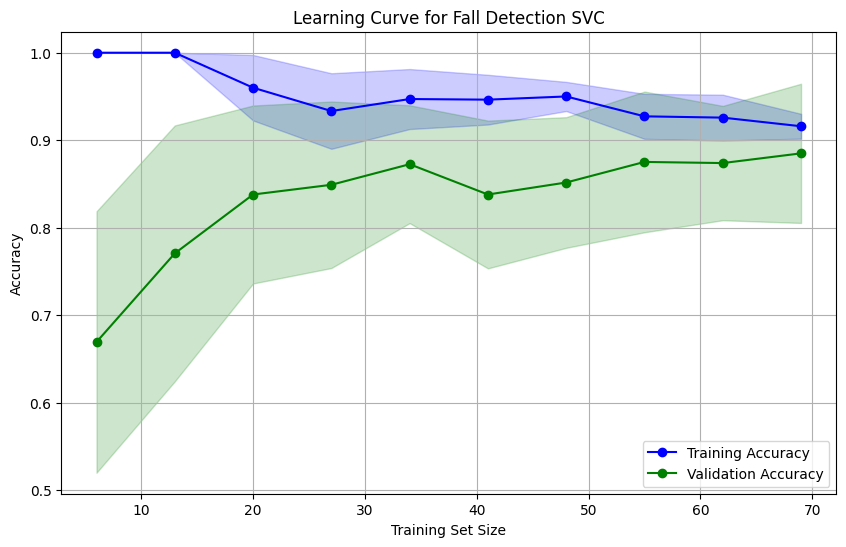

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training Accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.2)
plt.plot(train_sizes, valid_mean, 'o-', color='green', label='Validation Accuracy')
plt.fill_between(train_sizes, valid_mean - valid_std, valid_mean + valid_std, color='green', alpha=0.2)
plt.title('Learning Curve for Fall Detection SVC')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()